In [1]:
import os
import sys
sys.path.append(os.chdir('../'))

In [2]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import datetime

import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
import src.utils.graph as graph
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

tqdm.pandas()
pd.options.display.max_columns = None
pd.options.display.max_colwidth = -1

In [3]:
import src.data as data
import src.utility as utility

In [4]:
#base_df = data.base_structure()

caching base structure...


KeyboardInterrupt: 

In [4]:
#dataset_train = base_df.merge(data.base_dataset(), how='left')
dataset_train = data.base_dataset()

caching base dataset train


In [27]:
(dataset_train.duplicated(['KEY_2','DATETIME_UTC'])*1).sum()

800

In [29]:
dataset_train.shape

(10833282, 21)

In [28]:
dataset_train.drop_duplicates(['KEY_2','DATETIME_UTC']).shape

(10832482, 21)

In [5]:
dataset_train.head()

,KEY,DATETIME_UTC,KM,SPEED_AVG,SPEED_SD,SPEED_MIN,SPEED_MAX,N_VEHICLES,KEY_2,EMERGENCY_LANE,LANES,ROAD_TYPE,event_index,START_DATETIME_UTC,END_DATETIME_UTC,EVENT_DETAIL,EVENT_TYPE,KM_END,KM_START,KM_EVENT,step_duration
0,0,2018-09-01 01:00:00,443,97.889000,1.144099,97.080,98.698,2,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2018-09-01 03:15:00,443,154.788667,16.287509,137.530,169.890,3,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2018-09-01 12:45:00,443,136.091778,10.759666,124.586,163.418,18,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2018-09-01 19:15:00,443,136.916276,15.089653,114.878,169.890,58,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2018-09-02 09:45:00,443,135.476385,23.125778,82.518,169.890,26,0_443,1,2,1,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
def time_windows_event(dataset_df, steps_behind=10, steps_after=3, step=15*60):
    """ Filter the dataset to get a window containing n time steps before the beginning
        of the event and m time steps after the end for each involved sensor
        
        dataset_df (df): dataset
        steps_behind (int): n (not including the event start)
        steps_after (int): m (not including the event start)
    """
    # get the first time step of each event for each road
    start_events = dataset_df[dataset_df.event_index.notnull()]
    start_events = start_events[['KEY_2','event_index','DATETIME_UTC']].groupby(['KEY_2','event_index']).min()
    start_events = start_events.reset_index()[['KEY_2','DATETIME_UTC']]
    start_events['sample_id'] = start_events.index
    
    start_delta = datetime.timedelta(seconds=step*steps_behind)
    end_delta = datetime.timedelta(seconds=step*steps_after)
    
    # construct the time window for each event beginning
    start_events['window'] = start_events.apply(lambda x:
                                    list(pd.date_range(start=x.DATETIME_UTC - start_delta,
                                                       end=x.DATETIME_UTC + end_delta,
                                                       freq=f'{step}s')), axis=1)
    start_events = start_events.drop('DATETIME_UTC', axis=1)
    
    # build the filter
    filter_df = pd.DataFrame({ col: np.repeat(start_events[col].values, start_events['window'].str.len())
        for col in start_events.columns.drop('window')
    }).assign(**{'DATETIME_UTC': np.concatenate(start_events['window'].values)})
    
    # join to filter the desired rows
    return dataset_df.merge(filter_df.drop_duplicates(), how='inner', on=['KEY_2','DATETIME_UTC']) \
            .sort_values(['KEY','KM','DATETIME_UTC'])

In [8]:
start_events = dataset_train[dataset_train.event_index.notnull()][['KEY_2','event_index','DATETIME_UTC']]\
                .groupby(['KEY_2','event_index']).min().reset_index()

In [9]:
start_events['sample'] = start_events.reset_index().index

In [10]:
start_events.head()

,KEY_2,event_index,DATETIME_UTC,sample
0,0_337,16789.0,2018-09-05 18:15:00,0
1,0_337,17038.0,2018-09-15 11:15:00,1
2,0_337,17088.0,2018-09-17 16:15:00,2
3,0_337,17208.0,2018-09-20 16:30:00,3
4,0_337,17460.0,2018-10-01 17:00:00,4


In [11]:
start_events.shape

(885, 4)

In [42]:
start_events.reset_index().sort_values(['KEY_2','DATETIME_UTC']).head()

,KEY_2,event_index,DATETIME_UTC
9,0_337,34620.0,2018-09-01 11:30:00
0,0_337,16789.0,2018-09-05 18:15:00
1,0_337,17038.0,2018-09-15 11:15:00
2,0_337,17088.0,2018-09-17 16:15:00
3,0_337,17208.0,2018-09-20 16:30:00


In [40]:
def time_windows_event(dataset_df, steps_behind=10, steps_after=3, step=15*60):
    """ Filter the dataset to get a window containing n time steps before the beginning
        of the event and m time steps after the end for each involved sensor
        
        dataset_df (df): dataset dataframe
        steps_behind (int): n (not including the event start)
        steps_after (int): m (not including the event start)
    """
    # get the first time step of each event for sensor
    start_events = dataset_df[dataset_df.event_index.notnull()]
    start_events = start_events[['KEY_2','event_index','DATETIME_UTC']].groupby(['KEY_2','event_index']).min()
    start_events = start_events.reset_index()[['KEY_2','DATETIME_UTC']]
    start_events['sample_id'] = start_events.index
    
    start_delta = datetime.timedelta(seconds=step*steps_behind)
    end_delta = datetime.timedelta(seconds=step*steps_after)
    
    # construct the time window for each event beginning
    start_events['window'] = start_events.apply(lambda x:
                                    list(pd.date_range(start=x.DATETIME_UTC - start_delta,
                                                       end=x.DATETIME_UTC + end_delta,
                                                       freq=f'{step}s')), axis=1)
    start_events = start_events.drop('DATETIME_UTC', axis=1)
    
    # build the filter
    filter_df = pd.DataFrame({ col: np.repeat(start_events[col].values, start_events['window'].str.len())
        for col in start_events.columns.drop('window')
    }).assign(**{'DATETIME_UTC': np.concatenate(start_events['window'].values)})
    print(filter_df.shape)
    
    # join to filter the desired rows
    return dataset_df.merge(filter_df, how='right', on=['KEY_2','DATETIME_UTC']) \
            .sort_values(['KEY','KM','DATETIME_UTC'])

In [24]:
tw_df = utility.time_windows_event(dataset_train, steps_behind=10, steps_after=3)

(12390, 3)


In [24]:
tw_df.KEY.unique()

array([  0,   4,  10,  14,  16,  18,  21,  25,  27,  29,  31,  33,  37,
        39,  43,  46,  47,  48,  50, 102, 114, 118, 120, 122, 124, 132,
       134, 138, 146, 150, 154, 158, 164, 166, 172, 174, 178, 188, 198,
       204, 205, 209, 211, 213, 217, 219, 221, 226, 232, 234, 240, 242,
       244, 246, 248, 250, 252, 254, 260, 280, 292, 296, 298, 312, 314,
       322, 324, 326, 334, 338, 340, 344, 346, 352, 357, 363, 365, 369,
       373, 375, 379, 385, 389, 391, 393, 395, 396, 397, 407, 411, 412,
       417, 421, 423, 429, 431, 433, 439, 441, 445, 449, 451, 453, 455,
       457, 459, 463, 467, 469, 471, 475, 483, 485, 491, 497, 499, 512,
       517, 521])

In [7]:
tw_df.shape

(53985, 22)

In [12]:
tw_df.head()

,KEY,DATETIME_UTC,KM,SPEED_AVG,SPEED_SD,SPEED_MIN,SPEED_MAX,N_VEHICLES,KEY_2,EMERGENCY_LANE,LANES,ROAD_TYPE,event_index,START_DATETIME_UTC,END_DATETIME_UTC,EVENT_DETAIL,EVENT_TYPE,KM_END,KM_START,KM_EVENT,step_duration,sample_id
27863,0.0,2018-09-01 00:00:00,337.0,221.456031,34.159111,66.338,406.118,131.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
37072,0.0,2018-09-01 00:15:00,337.0,222.777354,32.214089,145.620,328.454,99.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
41717,0.0,2018-09-01 00:30:00,337.0,227.136381,32.773051,153.710,334.926,105.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
4641,0.0,2018-09-01 00:45:00,337.0,220.610783,29.403400,156.946,328.454,115.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9
30250,0.0,2018-09-01 01:00:00,337.0,220.220796,27.504985,158.564,284.768,103.0,0_337,1.0,2.0,1.0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,9


Number of sensors in road 0: 8


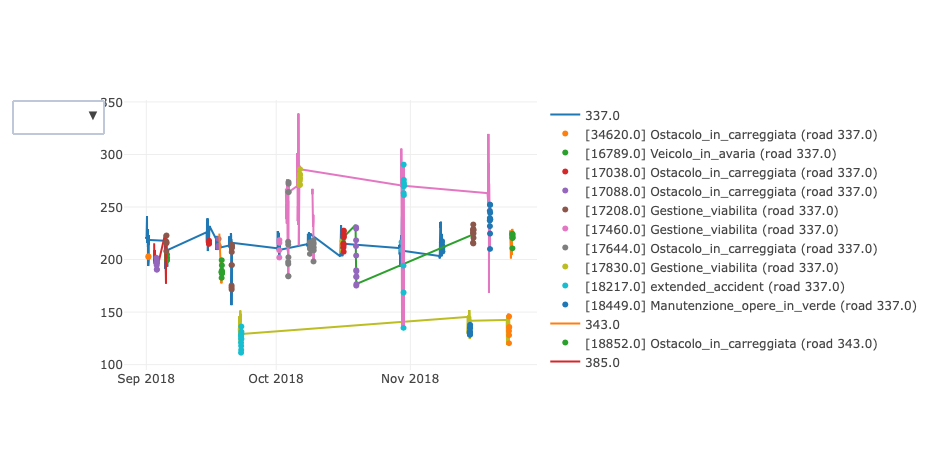

In [24]:
graph.show_speeds_with_events(tw_df, road_key=0, from_datetime='2010', to_datetime='2020')

In [35]:
tw_df.round(4).groupby('sample_id').agg({
    'KEY':'first',
    'KM':'first',
    'DATETIME_UTC':list,
    'SPEED_AVG':list, #[list, lambda x: x[0:-4].dropna().mean()],
    'SPEED_SD':list,
    'SPEED_MAX':list,
    'SPEED_MIN':list,
    'N_VEHICLES':list,
    'EMERGENCY_LANE':'first',
    'LANES':'first',
    'ROAD_TYPE':'first',
    'EVENT_DETAIL':list,
    'EVENT_TYPE':list})

,KEY,KM,DATETIME_UTC,SPEED_AVG,SPEED_SD,SPEED_MAX,SPEED_MIN,N_VEHICLES,EMERGENCY_LANE,LANES,ROAD_TYPE,EVENT_DETAIL,EVENT_TYPE
sample_id,,,,,,,,,,,,,
0,0.0,337.0,"[2018-09-05 15:45:00, 2018-09-05 16:00:00, 2018-09-05 16:15:00, 2018-09-05 16:30:00, 2018-09-05 16:45:00, 2018-09-05 17:00:00, 2018-09-05 17:15:00, 2018-09-05 17:30:00, 2018-09-05 17:45:00, 2018-09-05 18:00:00, 2018-09-05 18:15:00, 2018-09-05 18:30:00, 2018-09-05 18:45:00, 2018-09-05 19:00:00]","[204.6576, 209.3673, 203.2562, 198.8477, 209.527, 198.3578, 202.14, 206.7908, 204.8874, 197.4534, 199.6642, 199.315, 204.7759, 201.7721]","[48.0839, 37.7934, 48.39, 48.0002, 49.0868, 45.1328, 56.5317, 45.4386, 46.8656, 52.7926, 41.4457, 52.0643, 43.0659, 49.993]","[328.454, 323.6, 294.476, 279.914, 410.972, 323.6, 291.24, 389.938, 406.118, 406.118, 263.734, 292.858, 294.476, 312.274]","[59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866, 59.866]","[209.0, 173.0, 201.0, 214.0, 201.0, 180.0, 103.0, 186.0, 173.0, 141.0, 107.0, 129.0, 139.0, 193.0]",1.0,2.0,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 11.0, 11.0, 11.0, 11.0]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, Veicolo_in_avaria, Veicolo_in_avaria, Veicolo_in_avaria, Veicolo_in_avaria]"
1,0.0,337.0,"[2018-09-15 08:45:00, 2018-09-15 09:00:00, 2018-09-15 09:15:00, 2018-09-15 09:30:00, 2018-09-15 09:45:00, 2018-09-15 10:00:00, 2018-09-15 10:15:00, 2018-09-15 10:30:00, 2018-09-15 10:45:00, 2018-09-15 11:00:00, 2018-09-15 11:15:00, 2018-09-15 11:30:00, 2018-09-15 11:45:00, 2018-09-15 12:00:00]","[216.2554, 220.3449, 219.5438, 223.1256, 223.1036, 216.4681, 219.1444, 216.4075, 214.0762, 218.035, 214.8019, 215.5815, 217.9113, 220.268]","[38.7705, 32.5849, 26.5139, 26.5919, 32.5125, 32.7603, 31.1616, 32.9104, 32.1334, 28.4046, 33.1364, 31.9021, 30.1392, 27.3858]","[349.488, 331.69, 289.622, 349.488, 309.038, 383.466, 309.038, 281.532, 328.454, 291.24, 294.476, 330.072, 288.004, 299.33]","[59.866, 59.866, 59.866, 161.8, 64.72, 61.484, 59.866, 59.866, 61.484, 66.338, 59.866, 59.866, 61.484, 161.8]","[250.0, 218.0, 276.0, 286.0, 287.0, 334.0, 265.0, 280.0, 317.0, 299.0, 293.0, 309.0, 287.0, 250.0]",1.0,2.0,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 4.0, 4.0, 4.0, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, Ostacolo_in_carreggiata, Ostacolo_in_carreggiata, Ostacolo_in_carreggiata, nan]"
2,0.0,337.0,"[2018-09-17 13:45:00, 2018-09-17 14:00:00, 2018-09-17 14:15:00, 2018-09-17 14:30:00, 2018-09-17 14:45:00, 2018-09-17 15:00:00, 2018-09-17 15:15:00, 2018-09-17 15:30:00, 2018-09-17 15:45:00, 2018-09-17 16:00:00, 2018-09-17 16:15:00, 2018-09-17 16:30:00, 2018-09-17 16:45:00, 2018-09-17 17:00:00]","[222.4531, 219.0083, 221.2523, 216.126, 215.2863, 215.2823, 220.3851, 220.6781, 213.8336, 213.9111, 211.9201, 219.6707, 213.274, 215.4224]","[33.7272, 33.9104, 34.9611, 37.079, 33.4149, 39.0079, 32.5311, 30.2126, 34.9912, 39.1938, 29.6664, 29.4557, 34.4993, 36.5752]","[376.994, 328.454, 347.87, 328.454, 328.454, 328.454, 343.016, 406.118, 349.488, 283.15, 300.948, 300.948, 286.386, 349.488]","[61.484, 59.866, 63.102, 59.866, 59.866, 59.866, 59.866, 153.71, 59.866, 59.866, 59.866, 63.102, 59.866, 59.866]","[222.0, 249.0, 219.0, 250.0, 263.0, 220.0, 240.0, 208.0, 245.0, 169.0, 256.0, 223.0, 225.0, 255.0]",1.0,2.0,1.0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 4.0, 4.0, 4.0, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, Ostacolo_in_carreggiata, Ostacolo_in_carreggiata, Ostacolo_in_carreggiata, nan]"
3,0.0,337.0,"[2018-09-20 14:00:00, 2018-09-20 14:15:00, 2018-09-20 14:30:00, 2018-09-20 14:45:00, 2018-09-20 15:00:00, 2018-09-20 15:15:00, 2018-09-20 15:30:00, 2018-09-20 15:45:00, 2018-09-20 16:00:00, 2018-09-20 16:15:00, 2018-09-20 16:30:00, 2018-09-20 16:45:00, 2018-09-20 17:00:00, 2018-09-20 17:15:00]","[222.4932, 223.4066, 215.3581, 219.3922, 205.5001, 172.8512, 167.1401, 164.5032, 156.6054, 177.033, 173.4133, 175.3361, 171.4932, 194.